# ECE 57000 Assignment 5 Exercise

Your Name:

Prepare the pacakge we will use.

In [49]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Exercise 0: Train your model on GPU (0 points)

For some tasks in this assignment, it can take a long time if you run it on CPU. For example, based on our test on Exercise 3 Task 4, it will take roughly 2 hours to train the full model for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.

**Note**: If you would like to avoid GPU overages on Colab, we would suggest writing and debugging your code before switching on the GPU runtime. Otherwise, the time you spent debugging code will likely count against your GPU usage. Once you have the code running, you can switch on the GPU runtime and train the model much faster.

In [50]:
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [51]:
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------- <Your code> ---------------
rand_tensor = rand_tensor.to('cuda:0')
simple_model = simple_model.to('cuda:0')
# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Prepare train and test function

We will create our train and test procedure in these two functions. The train function should apply one epoch of training. The functions inputs should take everything we need for training and testing and return some logs.

#### Arguments requirement:
* For the `train` function, it takes the `model`, `loss_fn`, `optimizer`, `train_loader`, and `epoch` as arguments.
    * `model`: the classifier, or deep neural network, should be an instance of `nn.Module`.
    * `loss_fn`: the loss function instance. For example, `nn.CrossEntropy()`, or `nn.L1Loss()`, etc.
    * `optimizer`: should be an instance of `torch.optim.Optimizer`. For example, it could be `optim.SGD()` or `optim.Adam()`, etc.
    * `train_loader`: should be an instance of `torch.utils.data.DataLoader`.
    * `epoch`: the current number of epoch. Only used for log printing.(default: 1.)

* For the `test` function, it takes all the inputs above except for the optimizer (and it takes a test loader instead of a train loader).

#### Log requirement:
Here are some further requirements:
* In the `train` function, print the log 8-12 times per epoch. The print statement should be:
```python
print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
```
* In the `test` function, print the log after the testing. The print statement is:
```python
print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")
```

#### Return requirement
* The `train` function should return a list named `train_loss`, which the element is the loss per batch, i.e., one loss value for every batch.
* The `test` function should return a dictionary named `test_stat` with three keys: "loss", "accuracy", and "prediction". The values are the average loss of all the testset, average accuracy of all the test dataset, and the prediction of all test dataset.

#### Other requirement:
* In the `train` function, the model should be updated in-place, i.e., do not copy the model inside `train` function.

In [52]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------
    model.train()
    train_loss = []

    for batch_idx, (images, targets) in enumerate(train_loader):
      optimizer.zero_grad()
      output = model(images)
      loss =loss_fn(output, targets)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      # Print training progress multiple times per epoch
      if 8 <= batch_idx <= 12:
        #print(f'Epoch {epoch + 1}: [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')


      if batch_idx % 10 == 0: # We record our output every 10 batches
        train_losses.append(loss.item()) # item() is to get the value of the tensor directly
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      if batch_idx % 100 == 0: # We visulize our output every 10 batches
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')



    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    model.eval()
    test_loss = 0
    correct = 0
    all_predictions = []

    with torch.no_grad():
      for images, targets in test_loader:
        output = model(images)

        loss = loss_fn(output, targets)
        # Manually apply reduction by multiplying by batch size
        batch_size = images.size(0)
        loss *= batch_size

        test_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
        correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples

        # Append batch predictions to the list
        all_predictions.append(pred)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_counter.append(len(train_loader.dataset)*epoch)

    test_stat = {
      "loss": test_loss,
      "accuracy": correct,
      "prediction": torch.cat(all_predictions, dim=0)  # Concatenate the list of tensors
  }


    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

    # ----------- <End Your code> ---------------
    # dictionary output should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


### Task 2: Following the structure used in the instructions, you should create

*   One network named `OurFC` which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named `OurCNN` which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions.
* Notice You can always use the `train` and `test` function you write throughout this assignment.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)


In [53]:
# Download MNIST and transformation
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = torchvision.datasets.MNIST('data', train=True, download='True', transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download='True', transform=transform)
print(train_dataset)
# ----------- <End Your code> ---------------

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [54]:
batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

print(train_loader)

In [55]:
# Build OurFC class and OurCNN class.
# ----------- <Your code> ---------------
class OurFC(nn.Module):
  def __init__(self):
    super(OurFC, self).__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self,x):
     x = x.view(-1,784)
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = self.fc3(x)
     return F.log_softmax(x, -1)


class OurCNN(nn.Module):
    def __init__(self):
        super(OurCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.Conv2d(32, 64, 3)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 13 * 13, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 10)
        )

    def forward(self, x):
      x = self.conv(x)
      x = F.relu(x)
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 64 * 13 * 13)  # Flatten the tensor
      x = self.fc(x)
      x = F.relu(x)  # Apply ReLU activation
      x = F.log_softmax(x, dim=-1)  # Apply log_softmax
      return x





# ----------- <End Your code> ---------------

In [56]:
import torch.optim as optim

model = OurFC()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)



In [57]:
# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 3
# ----------- <Your code> ---------------
train_losses = []
train_counter = []
test_losses = []
test_counter = []


for epoch in range(1, max_epoch + 1):
  train(model, criterion, optimizer, train_loader, epoch)
  test(model, criterion, test_loader, epoch)
# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 2.299976348876953
Epoch 1: [512/60000] Loss: 2.261
Epoch 1: [576/60000] Loss: 2.244
Epoch 1: [640/60000] Loss: 2.263
Epoch 1: [704/60000] Loss: 2.227
Epoch 1: [768/60000] Loss: 2.253
Epoch 1: [6400/60000] Loss: 0.4324430823326111
Epoch 1: [12800/60000] Loss: 0.45769649744033813
Epoch 1: [19200/60000] Loss: 0.5015476942062378
Epoch 1: [25600/60000] Loss: 0.2913617491722107
Epoch 1: [32000/60000] Loss: 0.23374760150909424
Epoch 1: [38400/60000] Loss: 0.1532926857471466
Epoch 1: [44800/60000] Loss: 0.2633303105831146
Epoch 1: [51200/60000] Loss: 0.2179337590932846
Epoch 1: [57600/60000] Loss: 0.09224722534418106
Test result on epoch 1: Avg loss is 0.17839622344970704, Accuracy: 94.5999984741211%
Epoch 2: [0/60000] Loss: 0.16325148940086365
Epoch 2: [512/60000] Loss: 0.074
Epoch 2: [576/60000] Loss: 0.169
Epoch 2: [640/60000] Loss: 0.181
Epoch 2: [704/60000] Loss: 0.234
Epoch 2: [768/60000] Loss: 0.199
Epoch 2: [6400/60000] Loss: 0.2010062336921692
Epoch 2: [12800/

In [58]:
# Let's then train the OurCNN model.
start = time.time()
# ----------- <Your code> ---------------
criterion = nn.CrossEntropyLoss()
max_epoch = 3

# Create an instance of the OurNN model
model = OurCNN()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

train_losses = []
train_counter = []
test_losses = []
test_counter = []


for epoch in range(1, max_epoch + 1):

  train(model, criterion, optimizer, train_loader, epoch)
  test(model, criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 2.3103601932525635
Epoch 1: [512/60000] Loss: 2.172
Epoch 1: [576/60000] Loss: 2.089
Epoch 1: [640/60000] Loss: 2.101
Epoch 1: [704/60000] Loss: 2.028
Epoch 1: [768/60000] Loss: 2.066
Epoch 1: [6400/60000] Loss: 0.559618353843689
Epoch 1: [12800/60000] Loss: 0.5056039690971375
Epoch 1: [19200/60000] Loss: 0.05369490012526512
Epoch 1: [25600/60000] Loss: 0.23298507928848267
Epoch 1: [32000/60000] Loss: 0.02752746269106865
Epoch 1: [38400/60000] Loss: 0.06466955691576004
Epoch 1: [44800/60000] Loss: 0.05193733051419258
Epoch 1: [51200/60000] Loss: 0.13864679634571075
Epoch 1: [57600/60000] Loss: 0.08429376035928726
Test result on epoch 1: Avg loss is 0.07990743350982667, Accuracy: 97.56999969482422%
Epoch 2: [0/60000] Loss: 0.11096302419900894
Epoch 2: [512/60000] Loss: 0.072
Epoch 2: [576/60000] Loss: 0.028
Epoch 2: [640/60000] Loss: 0.133
Epoch 2: [704/60000] Loss: 0.035
Epoch 2: [768/60000] Loss: 0.079
Epoch 2: [6400/60000] Loss: 0.11877893656492233
Epoch 2: [

In [59]:
ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

OurFC has a total of 109386 parameters
OurCNN has a total of 1412298 parameters


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

Files already downloaded and verified
Files already downloaded and verified


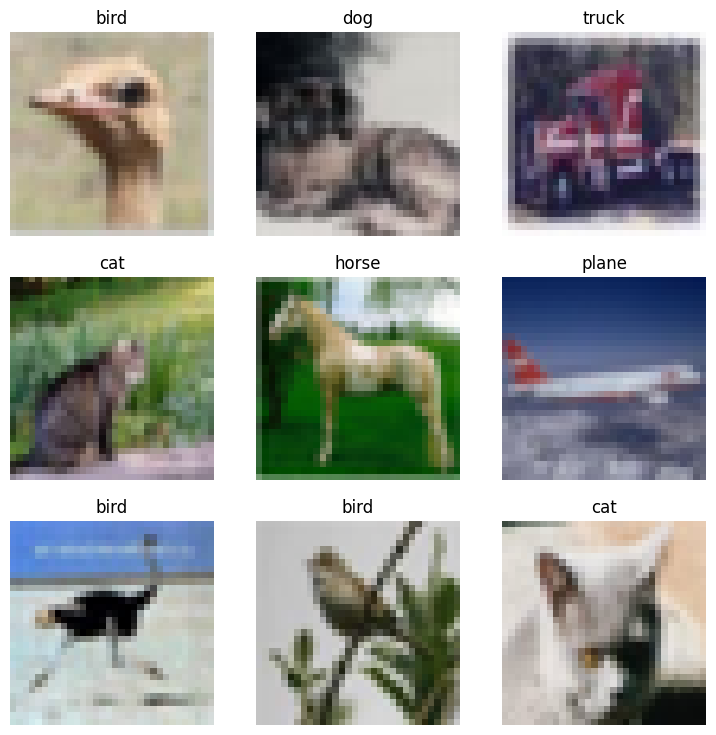

In [60]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

# ----------- <End Your code> ---------------

# Define trainloader and testloader
# ----------- <Your code> ---------------
batch_size_train, batch_size_test = 9, 9
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [61]:
# Create CNN network.
# ----------- <Your code> ---------------
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(32 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)  # 10 classes for CIFAR-10

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)
    x = x.view(-1, 32*8*8)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, -1)



# ----------- <End Your code> ---------------

In [62]:


def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------

          model.train()
          train_loss = []

          for batch_idx, (images, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss =loss_fn(output, targets)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            # Print training progress multiple times per epoch
            if 8 <= batch_idx <= 12:
              #print(f'Epoch {epoch + 1}: [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
              print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')


            if batch_idx % 10 == 0: # We record our output every 10 batches
              train_losses.append(loss.item()) # item() is to get the value of the tensor directly
              train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            if batch_idx % 100 == 0: # We visulize our output every 10 batches
              print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')



          # ----------- <End Your code> ---------------
          assert len(train_loss) == len(train_loader)
          return train_loss


def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------

    model.eval()
    test_loss = 0
    correct = 0
    all_predictions = []

    with torch.no_grad():
      for images, targets in test_loader:
        output = model(images)

        loss = loss_fn(output, targets)
        # Manually apply reduction by multiplying by batch size
        batch_size = images.size(0)
        loss *= batch_size

        test_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
        correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples

        # Append batch predictions to the list
        all_predictions.append(pred)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_counter.append(len(train_loader.dataset)*epoch)

    test_stat = {
      "loss": test_loss,
      "accuracy": correct,
      "prediction": torch.cat(all_predictions, dim=0)  # Concatenate the list of tensors
    }


    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

    # ----------- <End Your code> ---------------
    # dictionary output should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)

    return test_stat

In [63]:
# Train your neural network here.
start = time.time()
max_epoch = 4
# ----------- <Your code> ---------------

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

train_losses = []
train_counter = []
test_losses = []
test_counter = []

for epoch in range(1, max_epoch + 1):
  train(model, criterion, optimizer, train_loader, epoch)


# ----------- <End Your code> ---------------
output = test(model, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Loss: 2.2945809364318848
Epoch 1: [72/50000] Loss: 2.289
Epoch 1: [81/50000] Loss: 2.303
Epoch 1: [90/50000] Loss: 2.305
Epoch 1: [99/50000] Loss: 2.280
Epoch 1: [108/50000] Loss: 2.289
Epoch 1: [900/50000] Loss: 2.3196804523468018
Epoch 1: [1800/50000] Loss: 2.349724769592285
Epoch 1: [2700/50000] Loss: 1.8972265720367432
Epoch 1: [3600/50000] Loss: 2.1781814098358154
Epoch 1: [4500/50000] Loss: 2.200819253921509
Epoch 1: [5400/50000] Loss: 1.835268259048462
Epoch 1: [6300/50000] Loss: 1.619258165359497
Epoch 1: [7200/50000] Loss: 1.7645294666290283
Epoch 1: [8100/50000] Loss: 1.6561577320098877
Epoch 1: [9000/50000] Loss: 1.8574057817459106
Epoch 1: [9900/50000] Loss: 1.5676651000976562
Epoch 1: [10800/50000] Loss: 1.551822304725647
Epoch 1: [11700/50000] Loss: 1.8229403495788574
Epoch 1: [12600/50000] Loss: 1.5951732397079468
Epoch 1: [13500/50000] Loss: 2.878798484802246
Epoch 1: [14400/50000] Loss: 1.8928894996643066
Epoch 1: [15300/50000] Loss: 1.51186108589172

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

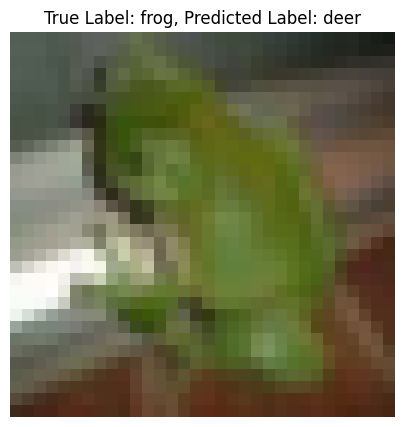

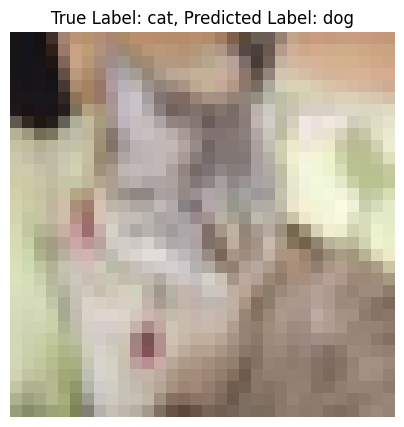

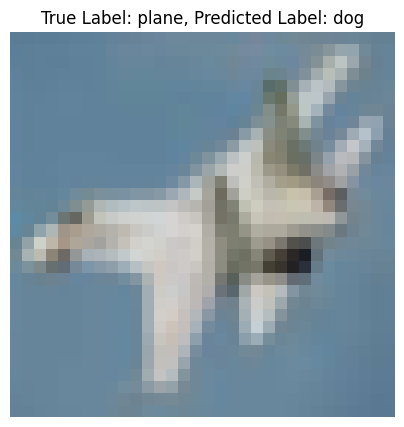

In [64]:
total_images = 3
predictions = output['prediction']
targets = torch.tensor(test_dataset.targets)

# ----------- <Your code> ---------------

# Create a list to store the misclassified image indices and their true/predicted labels
misclassified_count = 0
misclassified_images_info = []

# Iterate through the predictions and true labels to identify misclassified images
for i in range(len(predictions)):
    true_label = targets[i].item()
    predicted_label = predictions[i].item()

    if true_label != predicted_label:
        misclassified_images_info.append((i, true_label, predicted_label))
        misclassified_count += 1

        # If you have found enough misclassified images, break the loop
        if misclassified_count >= total_images:
            break

# Now, plot the selected misclassified images
for i, true_label, predicted_label in misclassified_images_info:
    misclassified_image = torch.tensor(test_dataset.data[i])

    # Plot the misclassified image
    plt.figure(figsize=(5, 5))
    plt.imshow(misclassified_image, cmap='gray')
    plt.title(f'True Label: {classes[true_label]}, Predicted Label: {classes[predicted_label]}')
    plt.axis('off')
    plt.show()


# ----------- <End Your code> ---------------

Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [76]:
resnet18 = models.resnet18(pretrained=True)
device = torch.device('cpu')
resnet18 = resnet18.to(device)

### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [77]:
# Create your dataloader here
# ----------- <Your code> ---------------
train_batch_size, test_batch_size = 128, 1000

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((244,244)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

])
train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
# ----------- <End Your code> ---------------

Files already downloaded and verified
Files already downloaded and verified


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [78]:
# ----------- <Your code> ---------------
start = time.time()
epoch = 5
test_sample = test_data[0][0]  # Access the first sample's data (image)

# Check the shape of the test sample
print("Shape of test sample:", test_sample.shape)

# Check the number of channels in the test sample
num_channels = test_sample.shape[0]
print("Number of channels in test sample:", num_channels)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
test_losses = []
test_counter = []



# ----------- <End Your code> ---------------
output = test(resnet18, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')
# ----------- <End Your code> ---------------

Shape of test sample: torch.Size([3, 244, 244])
Number of channels in test sample: 3
Test result on epoch 5: Avg loss is 8.852124329757691, Accuracy: 0.03999999910593033%
Finished Training after 13.74923586845398 s 


### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data.

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [ ]:
# Directly train the whole model.
start = time.time()
#----------- <Your code> ---------------
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.8)
max_epoch = 7
train_losses = []
train_counter = []

for epoch in range(1, max_epoch + 1):
  train(resnet18, criterion, optimizer, train_loader, epoch)
  test(resnet18, criterion, test_loader, epoch)
# ----------- <End Your code> ---------------
#test(resnet18, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Loss: 1.2018380165100098
Epoch 1: [72/50000] Loss: 0.960
Epoch 1: [81/50000] Loss: 1.707
Epoch 1: [90/50000] Loss: 0.966
Epoch 1: [99/50000] Loss: 1.267
Epoch 1: [108/50000] Loss: 1.111
Epoch 1: [900/50000] Loss: 1.0728702545166016


In [69]:
# Load another resnet18 instance, only unfreeze the outer layers.
# ----------- <Your code> ---------------
# Load a pretrained ResNet-18 model
new_resnet18 = models.resnet18(pretrained=True)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_resnet18.parameters(), lr=0.01, momentum=0.8)

# Freeze all layers except the final classification layer
for idx, param in enumerate(new_resnet18.parameters()):
        if idx < 6:
            param.requires_grad = False

# Modify the last fully connected layer for CIFAR-10
num_ftrs = new_resnet18.fc.in_features
new_resnet18.fc = nn.Linear(num_ftrs, 10)


# ----------- <End Your code> ---------------

In [70]:
# Train the model!!
start = time.time()
# ----------- <Your code> ---------------
max_epoch = 4
train_losses = []
train_counter = []
test_losses = []
test_counter = []

for epoch in range(1, max_epoch + 1):
  train(new_resnet18, criterion, optimizer, train_loader, epoch)
  test(new_resnet18, criterion, test_loader, epoch)
# ----------- <End Your code> ---------------
test(new_resnet18, criterion, test_loader)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Loss: 2.4725892543792725
Epoch 1: [72/50000] Loss: 3.345
Epoch 1: [81/50000] Loss: 2.532
Epoch 1: [90/50000] Loss: 2.587
Epoch 1: [99/50000] Loss: 2.283
Epoch 1: [108/50000] Loss: 2.503
Epoch 1: [900/50000] Loss: 1.7554421424865723
Epoch 1: [1800/50000] Loss: 1.6226454973220825
Epoch 1: [2700/50000] Loss: 2.343838691711426
Epoch 1: [3600/50000] Loss: 1.5753061771392822
Epoch 1: [4500/50000] Loss: 1.3424793481826782
Epoch 1: [5400/50000] Loss: 1.702919602394104
Epoch 1: [6300/50000] Loss: 1.7562144994735718
Epoch 1: [7200/50000] Loss: 1.8009238243103027
Epoch 1: [8100/50000] Loss: 1.6246627569198608
Epoch 1: [9000/50000] Loss: 1.3602992296218872
Epoch 1: [9900/50000] Loss: 1.9821455478668213
Epoch 1: [10800/50000] Loss: 1.8268835544586182
Epoch 1: [11700/50000] Loss: 1.5871148109436035
Epoch 1: [12600/50000] Loss: 1.1694942712783813
Epoch 1: [13500/50000] Loss: 1.1847251653671265
Epoch 1: [14400/50000] Loss: 0.7684045433998108
Epoch 1: [15300/50000] Loss: 0.6829043030